# Vizualizing meandering with Python

Inspired from work of Zoltán Sylvester,Bureau of Economic Geology, and made with Dr. Al Ibrahim for Quantitative Sequence Stratigraphy project.

Added features: 
1. Stream cutoff when segments meet, forming an ox-bow lake.
2. Removed achoring artifact.
3. Width added to the river.
4. Aggradation (basw level rising due to deposition of sediments) incorporated.

In [10]:
import numpy as np
from math import pi
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import scipy.interpolate
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,6) # set the default figure size to (9,6)

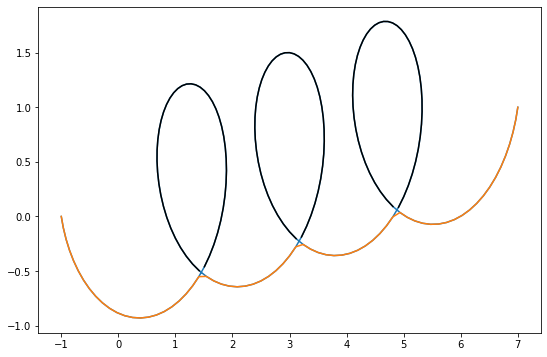

In [11]:
# based on https://www.mathworks.com/matlabcentral/fileexchange/13351-fast-and-robust-self-intersections
def selfIntersect(x,y):
    # Create output
    x0=[];
    y0=[];
    
    segments=[];

    # Two similar curves are firstly created.
    x1=x; x2=x;
    y1=y; y2=y;

    # Compute number of line segments in each curve and some differences we'll need later.
    n1 = len(x1) - 1;
    n2 = len(x2) - 1;

    dxy1 = np.diff(np.array([x1, y1]).T, axis=0);
    dxy2 = np.diff(np.array([x2, y2]).T, axis=0);


    # Determine the combinations of i and j where the rectangle enclosing the
    # i'th line segment of curve 1 overlaps with the rectangle enclosing the
    # j'th line segment of curve 2.
    r1 = np.tile(np.min(np.array([x1[0:-1],x1[1:]]).T, axis=1),[n2,1]).T
    r2 = np.tile(np.max(np.array([x2[0:-1],x2[1:]]).T, axis=1),[n1,1])
    r3 = np.tile(np.max(np.array([x1[0:-1],x1[1:]]).T, axis=1),[n2,1]).T
    r4 = np.tile(np.min(np.array([x2[0:-1],x2[1:]]).T, axis=1),[n1,1])
    r5 = np.tile(np.min(np.array([y1[0:-1],y1[1:]]).T, axis=1),[n2,1]).T
    r6 = np.tile(np.max(np.array([y2[0:-1],y2[1:]]).T, axis=1),[n1,1])
    r7 = np.tile(np.max(np.array([y1[0:-1],y1[1:]]).T, axis=1),[n2,1]).T
    r8 = np.tile(np.min(np.array([y2[0:-1],y2[1:]]).T, axis=1),[n1,1])
    [j, i] = np.where(np.logical_and(np.logical_and(r1<=r2, r3>=r4), np.logical_and(r5<=r6, r7>=r8)))
    # Removing coincident and adjacent segments.
    
    remove=np.where(np.abs(i-j)<2)
    i = np.delete(i, remove)
    j = np.delete(j, remove)
    

    # Removing duplicate combinations of segments.
    remove=np.array([], dtype='int');
    for ii in range(0, len(i)):
        ind = np.where(np.logical_and((i[ii]==j[ii:]), j[ii]==i[ii:]));
        ind = np.array(ind);
        remove= np.append(remove,ii+ind)
    i = np.delete(i, remove)
    j = np.delete(j, remove)


    # Find segments pairs which have at least one vertex = NaN and remove them.
    # This line is a fast way of finding such segment pairs.  We take
    # advantage of the fact that NaNs propagate through calculations, in
    # particular subtraction (in the calculation of dxy1 and dxy2, which we
    # need anyway) and addition.
    remove = np.where(np.isnan(np.sum(dxy1[i,:] + dxy2[j,:],axis=1)));
    i = np.delete(i, remove)
    j = np.delete(j, remove)


    xNew = np.copy(x)
    yNew = np.copy(y)
    xCut = np.copy(x)
    yCut = np.copy(y)

    remove=np.array([], dtype='int');
    for ii in range(0,len(i)):
        remove = np.append(remove, np.arange(j[ii]+1,i[ii]+1))
    xNew = np.delete(xNew, remove)
    yNew = np.delete(yNew, remove)
    
    keep = np.setdiff1d(np.array(np.arange(0,len(x))), remove)
    xCut[keep] = np.nan
    yCut[keep] = np.nan
    
    return xNew, yNew, xCut, yCut, keep

#Examplr/test
# Create the data
N=201;
th=np.linspace(-3*pi,4*pi,N);
R=1;
x=R*np.cos(th)+np.linspace(0,6,N);
y=R*np.sin(th)+np.linspace(0,1,N);

xNew, yNew, xCut, yCut, keep = selfIntersect(x,y)
plt.figure()
plt.plot(x,y)
plt.plot(xNew,yNew)
plt.plot(xCut, yCut, 'k')


## Convolution (Howard & Knutson) model


All three approaches discussed so far are just geometric curves; and there is no easy way to construct a sequence of centerlines that would correpsond to the long-term evolution of a channel (although it is not that difficult to construct a series of lines of increasing sinuosity, with no downstream variability in meander bends). All actual forward models of meandering channels rely on linking the lateral migration rate to channel curvature. Models that link the lateral migration rate to the excess velocity along channel banks suggest that it is not only the lcoal curavture that determines the excess velocity (and therefore migration rate), but curvatures at upstream locations need to be considered as well, with upstream decreasing influence. The simplest meandering model links migration rates directly to curvatures (without calculating velocities) and was described by Howard and Knuston (Howard, A.D., and Knutson, T., 1984, Sufficient Conditions for River Meandering: A Simulation Approach: Water Resources Research, v. 20, no. 11, p. 1659–1667). The following script is a bare-bones Python implementation of the Howard & Knutson model.

The Howard and Knutson model is based on the calculation of an adjusted channel migration rate $R_1$ from a nominal migration rate $R_0$, using a weighting function $G(\xi)$:

$$ R_1(s) = \Omega R_0(s) + \Big(\Gamma \int_{0}^{\infty}R_0(s-\xi)G(\xi)d\xi\Big) \Big(\int_{0}^{\infty}G(\xi)d\xi\Big)^{-1} $$

$$ R_0 = k_l \frac{W}{R} $$
                                                  
where $R_0(s)$ and $R_0(s-\xi)$ are the nominal migration rates at locations $s$ and at a distance $\xi$ upstream from $s$, respectively. \Omega and \Gamma are weighting parameters that are set to -1 and 2.5 respectively, to produce one of the two parameterizations of stable meandering (Howard and Knutson, 1984). $G(\xi)$ is a weighting function that decreases exponentially in the upstream direction:

$$ G(\xi) = e^{-\alpha\xi} $$

For additional details see the supplementary material to the following paper: Sylvester, Z., and Covault, J.A., 2016, Development of cutoff-related knickpoints during early evolution of submarine channels: Geology, v. 44, no. 10, p. 835–838, doi: 10.1130/G38397.1.

Note that the script below does not address meander cutoffs; once the centerline starts intersecting itself, the results are meaningless. The way cutoffs are treated is an important (and non-trivial) part of a long-term evolution model.

### Run model

In [5]:
# Compare curvature and wavelength. Distribution of curvature. Change noise. How does changing width change origninal results
# Effect of changing slope in k
import matplotlib.path as mpltPath

agg_rate = 1.0 # Added
D = 5.0 # channel depth in meters
W = D*20.0 # channel width in meters
kl = 1.5E-7 # lateral erosion rate constant (m/s) 
dt = 6*30*24*60*60 * W/100 # time step in seconds (~ 6 months for W = 100 m)
Cf1 = 0.03 # dimensionless Chezy friction factor
Cf2 = 0.04 # Say different for different lithology
nit = 1000 # number of time steps
saved_ts = 1 # every 'saved_ts' time step is saved 
delta_s = W*0.25
noisy_len = 8000 # length of noisy part of initial centerline
pLeft = 20 # length of padding (no noise on this)
pRight = 2
k = 1 # constant in equation for exponent in curvature calculation 
omega = -1.0 # constant in curvature calculation (Howard and Knutson, 1984)
gamma = 2.5 # from Ikeda et al., 1981 and Howard and Knutson, 1984
# alpha = k*2*Cf/D # exponent for convolution function G
p=[]
# CREATE INITIAL CENTERLINE COORDINATES
x = np.linspace(0, noisy_len+(pLeft+pRight)*delta_s, int(noisy_len/delta_s+(pLeft+pRight))+1) 
y = 1.0 * (2*np.random.random_sample(int(noisy_len/delta_s)+1,)-1)
ypadLeft = np.zeros((pLeft),)
ypadRight = np.zeros((pRight),)
y = np.hstack((ypadLeft,y,ypadRight))

dx = np.diff(x); dy = np.diff(y)      
ds = np.sqrt(dx**2+dy**2) # initial distances between points along centerline
dxMax = dx[0];

# LISTS FOR STORING RESULTS
X, Y = [], []
X1, Y1 = [], []
X2, Y2 = [], []
OXBOWX, OXBOWY = [], []
CURVATURE = []
MIGRATION_RATE=[]
NOMINAL_MIGRATION_RATE=[]
TIME = []

#X.append(x)
#Y.append(y)
#cut = np.zeros_like(x)*np.nan
#OXBOWX.append(cut)
#OXBOWY.append(cut)

yCut = []
xCut = []


for itn in range(1,nit): # main loop
    ns=len(x)    
    
    # COMPUTE CURVATURE
    ddx = np.diff(dx); ddy = np.diff(dy);      
    curv = W*(dx[1:]*ddy-dy[1:]*ddx)/((dx[1:]**2+dy[1:]**2)**1.5) # curvature
    # COMPUTE MIGRATION RATE
    R0 = kl*curv # nominal migration rate
    R1 = np.zeros(ns-2) # preallocate adjusted channel migration rate
    
    #%% Added 31/1/19 Boundaries of the stream
    dx = np.diff(x); dy = np.diff(y); dx = np.append(dx[0],dx); dy = np.append(dy[0],dy)
    ddx = np.diff(dx); ddy = np.diff(dy)
    t = np.arctan(dy/dx)
    x1 = x + W *np.sin(t)*np.sign(dx)
    y1 = y - W *np.cos(t)*np.sign(dx)
    x2 = x - W *np.sin(t)*np.sign(dx)
    y2 = y + W *np.cos(t)*np.sign(dx)
    #%%
    
    for i in range(pLeft,ns-pRight):
        
        #%% Added erosion, change Cf
        inside = False #reset
        if itn > D*agg_rate:
            for past_time in range(1,int(D*agg_rate+1)):
                xp1 = X1[-past_time]; yp1 = Y1[-past_time]; 
                xp2r = X2[-past_time][::-1]; yp2r = Y2[-past_time][::-1] #reverse order
        
                # Create polygon
                xp = np.hstack((xp1,xp2r)); yp = np.hstack((yp1, yp2r));
                xy = np.array([xp,yp]).T
                path = mpltPath.Path(xy)
                
                #Eroding side
                if curv[i]<0: inside2 = path.contains_points([[x1[i],y1[i]]])
                else: inside2 = path.contains_points([[x2[i],y2[i]]])
                    
            inside = inside or inside2    
                    
        if inside==True: Cf = Cf2
        else: Cf = Cf1
        #%%
        
        
        alpha = k*2*Cf/D # exponent for convolution function G
        si2 = np.cumsum(ds[i::-1]) # distance along centerline, backwards from current point
        G = np.exp(-alpha*si2) # convolution vector
        R1[i-1] = omega*R0[i-1] + gamma*np.sum(R0[i-1::-1]*G[:-1])/np.sum(G[:-1]) # adjusted migration rate
    # COMPUTE NEW COORDINATES
    x[pLeft:ns-pRight] = x[pLeft:ns-pRight] + R1[pLeft-1:ns-pRight-1]*dt*np.diff(y[pLeft:ns-pRight+1])/ds[pLeft:ns-pRight]
    y[pLeft:ns-pRight] = y[pLeft:ns-pRight] - R1[pLeft-1:ns-pRight-1]*dt*np.diff(x[pLeft:ns-pRight+1])/ds[pLeft:ns-pRight]   
    
    y[ns-pRight-pRight:] = y[ns-pRight-pRight:]*0+y[ns-pRight-pRight-1] 
#     x, y, xCut, yCut  = selfIntersect(x,y)
    

    #%% Added 31/1/19
    x1New, y1New, x1Cut, y1Cut, keep1 = selfIntersect(x1,y1)
    x2New, y2New, x2Cut, y2Cut, keep2 = selfIntersect(x2,y2)
    keep = sorted(list(set(keep1) & set(keep2)))
    x = x[keep]; y = y[keep]
    #%%
    
    # RESAMPLE CENTERLINE
    tck, u = scipy.interpolate.splprep([x,y],s=0) # parametric spline representation of curve (for resampling)
    unew = np.linspace(0,1,1+int(np.sum(ds)/delta_s)) # vector for resampling
    out = scipy.interpolate.splev(unew,tck) # actual resampling
    x = out[0]
    y = out[1]
    
    # COMPUTE DISTANCES BETWEEN NEW POINTS
    dx = np.diff(x); dy = np.diff(y)      
    ds = np.sqrt(dx**2+dy**2) # distances between points along centerline
    # STORE RESULTS
    if np.mod(itn,saved_ts)==0:
        X.append(x)
        Y.append(y)
        X1.append(x1); Y1.append(y1); X2.append(x2); Y2.append(y2)
        OXBOWX.append(xCut)
        OXBOWY.append(yCut)
        CURVATURE.append(curv)
        TIME.append(itn)
        MIGRATION_RATE.append(R1)
        NOMINAL_MIGRATION_RATE.append(R0)

In [6]:
backInTime = 400

@interact(ts=(0,len(X)-1,30),xloc=(-1000,7000,50),zoom=(-5000,5000,100))
def plot_clines(ts=0,xloc=0,zoom=-2000):
    fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.axes()
    plt.text(0.01, 0.95, 'Timestep: ' + str(TIME[ts]), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=28)
    plt.text(.025, .57, 'Flow', horizontalalignment='left', verticalalignment='bottom', fontsize=20, transform=ax.transAxes)
    ax.arrow(.005, .55, .1,0, width = .01, head_width=.05, head_length=.01, fc='k', ec='k', transform=ax.transAxes)

    startTime = np.max(np.array([0,ts-backInTime]))
    j = 1.05
    for i in np.arange(startTime,ts,20):
        j = j-0.05
        plt.plot(X[i],Y[i],lw=1,color=(0.9*j,0.9*j,0.9*j)) #Changed 31/1
    for i in np.arange(startTime,ts,1):
        if np.any(~np.isnan(OXBOWX[i])):
            plt.plot(OXBOWX[i],OXBOWY[i],lw=2,color=(1,.7,0))
        
    plt.plot(X[ts],Y[ts],lw=2,color=(0.04,0.37,0.59))
    plt.plot(X1[ts],Y1[ts],lw=2,color=(1,0,0))
    plt.plot(X2[ts],Y2[ts],lw=2,color=(0,1,0))
    plt.plot(OXBOWX[ts],OXBOWY[ts],lw=6,color=(1,.7,0))
#     plt.xticks([]) 
#     plt.yticks([])
    plt.xlim(xloc,np.max(X[0][-1])+800)
    plt.ylim(-(3000-zoom)/3.0,(3000-zoom)/3.0)
    plt.show()


interactive(children=(IntSlider(value=0, description='ts', max=998, step=30), IntSlider(value=0, description='…

interactive(children=(IntSlider(value=0, description='ts', max=998, step=30), IntSlider(value=0, description='…

<IPython.core.display.Javascript object>


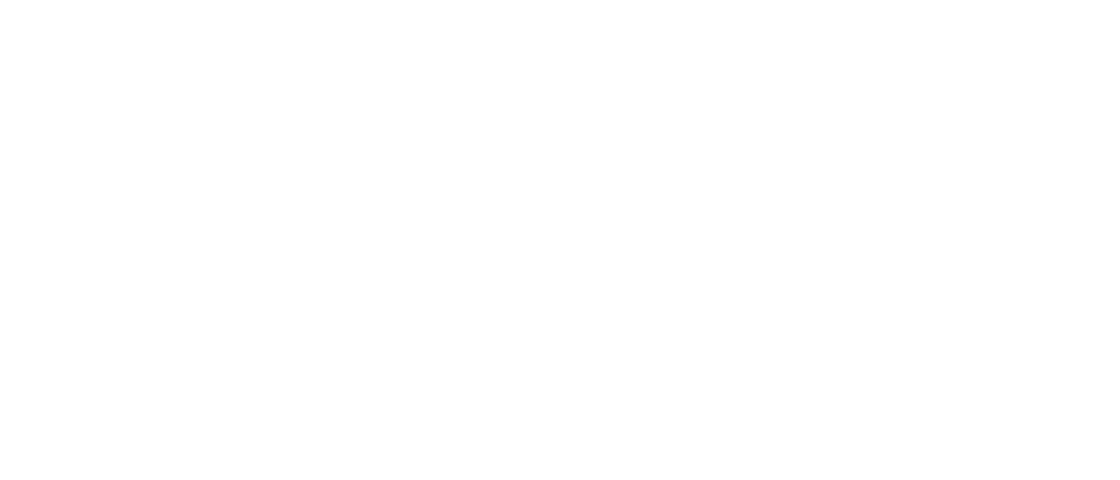

In [7]:
backInTime = 400
z = np.linspace(1,1000,1000)
%matplotlib notebook
import matplotlib.pyplot as plt
@interact(ts=(0,len(X)-1,30),xloc=(-1000,7000,50),zoom=(-5000,5000,100))
def plot_clines(ts=0,xloc=0,zoom=-2000):
    from mpl_toolkits import mplot3d


    fig = plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.axes(projection='3d')
#     plt.text(0.01, 0.95, 'Timestep: ' + str(TIME[ts]), horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=28)
#     plt.text(.025, .57, 'Flow', horizontalalignment='left', verticalalignment='bottom', fontsize=20, transform=ax.transAxes)
#     ax.arrow(.005, .55, .1,0, width = .01, head_width=.05, head_length=.01, fc='k', ec='k', transform=ax.transAxes)

    startTime = np.max(np.array([0,ts-backInTime]))
    for i in np.arange(startTime,ts,20):
        ax.plot3D(X[i],Y[i],z[i],lw=1,color=(0.5,0.5,0.5))
    for i in np.arange(startTime,ts,1):
        if np.any(~np.isnan(OXBOWX[i])):
            ax.plot3D(OXBOWX[i],OXBOWY[i],z[i],lw=2,color=(1,.7,0))
        
    ax.plot3D(X[ts],Y[ts],z[ts],lw=2,color=(0.04,0.37,0.59))
    ax.plot3D(X1[ts],Y1[ts],z[ts],lw=2,color=(1,0,0))
    ax.plot3D(X2[ts],Y2[ts],z[ts],lw=2,color=(0,1,0))
    ax.plot3D(OXBOWX[ts],OXBOWY[ts],z[ts],lw=6,color=(1,.7,0))
#     ax.xticks([]) 
#     ax.yticks([])
#     plt.zticks([])
    ax.set_xlim(xloc,np.max(X[0][-1])+800)
    ax.set_ylim(-(3000-zoom)/3.0,(3000-zoom)/3.0)
#     ax.show()


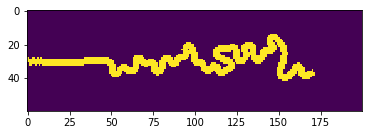

In [9]:
# How do you find all the points lying inside the channel boundaries: 2D
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

X2r = [elem[::-1] for elem in X2]
Y2r = [elem[::-1] for elem in Y2]

# x = [16,121,180,0]; y = [152,153,182,0]
x = np.hstack((X1[600], X2r[600])); y = np.hstack((Y1[600], Y2r[600]));
xy = np.array([x,y]).T
# print(xy.shape)
p = matplotlib.patches.Polygon(xy)


x, y = np.meshgrid(np.arange(0,10000,50), np.arange(-1500,1500,50)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 


grid = p.contains_points(points)
mask = grid.reshape(60,200) # now you have a mask with points inside a polygon
plt.imshow(mask)